In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_indices(idxs, train_frac=0.7, val_frac=0.15):
    idxs = np.array(idxs, dtype=np.int64)
    n = len(idxs)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train = idxs[:n_train]
    val = idxs[n_train:n_train + n_val]
    test = idxs[n_train + n_val:]
    return train, val, test

In [3]:
def scale_time_amount(X):
    X = X.copy()
    X[:, time_idx] = (X[:, time_idx] - time_mean) / time_std
    X[:, amt_idx]  = (X[:, amt_idx]  - amt_mean)  / amt_std
    return X

In [4]:
url = '/kaggle/input/creditcardfraud/creditcard.csv'

df = pd.read_csv(url)

df.head()
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
X_df = df.drop(columns=["Class"]).copy()
y_np = df["Class"].astype(np.int64).values
X_np = X_df.values.astype(np.float32)

In [6]:
time_idx = X_df.columns.get_loc("Time")
amt_idx  = X_df.columns.get_loc("Amount")

In [7]:
pos_idx = np.where(y_np == 1)[0]
neg_idx = np.where(y_np == 0)[0]

In [8]:
rng = np.random.default_rng(42)

pos_idx = np.where(y_np == 1)[0]
neg_idx = np.where(y_np == 0)[0]
rng.shuffle(pos_idx)
rng.shuffle(neg_idx)
pos_tr, pos_va, pos_te = split_indices(pos_idx)
neg_tr, neg_va, neg_te = split_indices(neg_idx)
train_idx = np.concatenate([pos_tr, neg_tr])
val_idx = np.concatenate([pos_va, neg_va])
test_idx = np.concatenate([pos_te, neg_te])
rng.shuffle(train_idx)
rng.shuffle(val_idx)
rng.shuffle(test_idx)

In [9]:
X_train, y_train = X_np[train_idx], y_np[train_idx]
X_val,   y_val   = X_np[val_idx],   y_np[val_idx]
X_test,  y_test  = X_np[test_idx],  y_np[test_idx]

In [10]:
time_mean, time_std = X_train[:, time_idx].mean(), X_train[:, time_idx].std() + 1e-8
amt_mean,  amt_std  = X_train[:, amt_idx].mean(),  X_train[:, amt_idx].std() + 1e-8
X_train = scale_time_amount(X_train)
X_val   = scale_time_amount(X_val)
X_test  = scale_time_amount(X_test)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

batch_size = 4096
train_loader = DataLoader(FraudDataset(X_train, y_train), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(FraudDataset(X_val, y_val), batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(FraudDataset(X_test, y_test), batch_size=batch_size, shuffle=False, pin_memory=True)

In [12]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1)  # output logits
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(in_dim=X_train.shape[1]).to(device)
print("input dims:", X_train.shape[1])

input dims: 30


In [13]:
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("neg:", neg, "pos:", pos, "pos_weight:", pos_weight.item())

neg: 199020 pos: 344 pos_weight: 578.5465087890625


In [14]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [15]:
@torch.no_grad()
def predict_probs(loader):
    model.eval()
    probs_list = []
    y_list = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu()
        probs_list.append(probs)
        y_list.append(yb.detach().cpu())
    return torch.cat(y_list).numpy(), torch.cat(probs_list).numpy()

def run_train_epoch(loader):
    model.train()
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    return total_loss / n

In [16]:
def roc_auc_manual(y_true, y_score):
    # ranks based AUC, no sklearn
    y_true = y_true.astype(np.int64)
    y_score = y_score.astype(np.float64)

    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=np.float64)
    ranks[order] = np.arange(len(y_score), dtype=np.float64) + 1.0

    pos = y_true == 1
    n_pos = pos.sum()
    n_neg = len(y_true) - n_pos
    if n_pos == 0 or n_neg == 0:
        return np.nan

    sum_ranks_pos = ranks[pos].sum()
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

def pr_auc_manual(y_true, y_score):
    # average precision (PR AUC approximation) from sorted scores
    y_true = y_true.astype(np.int64)
    order = np.argsort(-y_score)
    y_true = y_true[order]

    tp = 0
    fp = 0
    ap = 0.0
    n_pos = y_true.sum()
    if n_pos == 0:
        return np.nan

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
            ap += tp / (tp + fp)
        else:
            fp += 1
    ap /= n_pos
    return float(ap)

In [17]:
epochs = 10
best_val_ap = -1.0
best_state = None
patience = 3
pat = 0

for epoch in range(1, epochs + 1):
    train_loss = run_train_epoch(train_loader)

    # evaluate on val
    val_y, val_probs = predict_probs(val_loader)
    val_auc = roc_auc_manual(val_y, val_probs)
    val_ap = pr_auc_manual(val_y, val_probs)

    print(f"Epoch {epoch:02d} | train loss {train_loss:.5f} | val ROC-AUC {val_auc:.5f} | val PR-AUC {val_ap:.5f}")

    # early stop on PR-AUC
    if val_ap > best_val_ap:
        best_val_ap = val_ap
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping")
            break

# load best model
model.load_state_dict(best_state)
print("Best val PR-AUC:", best_val_ap)

Epoch 01 | train loss 1.12261 | val ROC-AUC 0.95316 | val PR-AUC 0.66742
Epoch 02 | train loss 0.67726 | val ROC-AUC 0.96712 | val PR-AUC 0.65326
Epoch 03 | train loss 0.59683 | val ROC-AUC 0.97519 | val PR-AUC 0.65324
Epoch 04 | train loss 0.52659 | val ROC-AUC 0.97964 | val PR-AUC 0.65261
Early stopping
Best val PR-AUC: 0.6674169442997007


In [18]:
test_y, test_probs = predict_probs(test_loader)
test_auc = roc_auc_manual(test_y, test_probs)
test_ap = pr_auc_manual(test_y, test_probs)
print("Test ROC-AUC:", test_auc, "Test PR-AUC:", test_ap)

Test ROC-AUC: 0.973685674982805 Test PR-AUC: 0.7328327374579339


In [19]:
order = np.argsort(-test_probs)
sorted_probs = test_probs[order]
sorted_y = test_y[order]

tp = 0
fp = 0
fn = int(sorted_y.sum())
best_f1 = -1.0
best_thr = 0.5

for i in range(len(sorted_y)):
    if sorted_y[i] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
    prec = tp / (tp + fp + 1e-12)
    rec = tp / (tp + fn + 1e-12)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)

    # threshold is current score value
    thr = sorted_probs[i]
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold (by F1):", best_thr, "Best F1:", best_f1)

Best threshold (by F1): 0.9637832 Best F1: 0.7272727272722226


In [20]:
pred = (test_probs >= best_thr).astype(np.int64)

tn = int(((pred == 0) & (test_y == 0)).sum())
fp = int(((pred == 1) & (test_y == 0)).sum())
fn = int(((pred == 0) & (test_y == 1)).sum())
tp = int(((pred == 1) & (test_y == 1)).sum())

print("Confusion Matrix")
print("TN:", tn, "FP:", fp)
print("FN:", fn, "TP:", tp)

precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)
print("Precision:", precision, "Recall:", recall)

Confusion Matrix
TN: 42618 FP: 30
FN: 15 TP: 60
Precision: 0.6666666666666593 Recall: 0.7999999999999894


Test set size: 42723
Total fraud in test: 75
Base fraud rate: 0.0017554946984060108

Top-K Review Queue Results
K | Fraud Caught | Precision@K | Recall@K | Lift
   50 |          40 |      0.8000 |   0.5333 | 455.71
  100 |          62 |      0.6200 |   0.8267 | 353.18
  200 |          66 |      0.3300 |   0.8800 | 187.98
  500 |          67 |      0.1340 |   0.8933 |  76.33
 1000 |          67 |      0.0670 |   0.8933 |  38.17
 2000 |          68 |      0.0340 |   0.9067 |  19.37
 5000 |          70 |      0.0140 |   0.9333 |   7.97


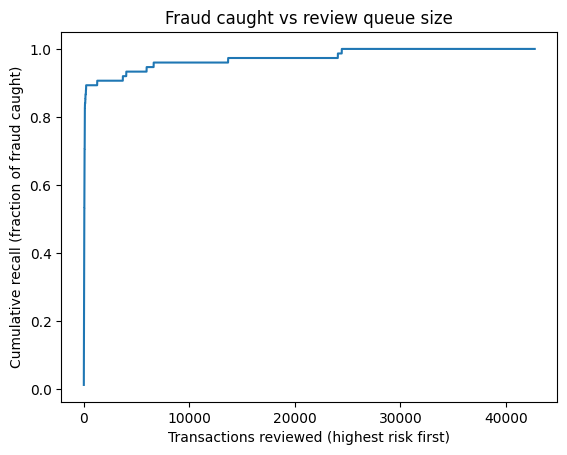

To catch 50% of fraud, review about 48 transactions
To catch 75% of fraud, review about 86 transactions
To catch 90% of fraud, review about 1264 transactions


In [21]:
def topk_report(y_true, probs, ks):
    y_true = y_true.astype(np.int64)
    probs = probs.astype(np.float64)

    order = np.argsort(-probs)
    y_sorted = y_true[order]

    total = len(y_true)
    total_fraud = int(y_true.sum())
    base_rate = total_fraud / total

    rows = []
    for k in ks:
        k = int(min(k, total))
        topk = y_sorted[:k]
        fraud_caught = int(topk.sum())
        precision_at_k = fraud_caught / k
        recall_at_k = fraud_caught / (total_fraud + 1e-12)
        lift = precision_at_k / (base_rate + 1e-12)
        rows.append((k, fraud_caught, precision_at_k, recall_at_k, lift))

    return base_rate, total_fraud, total, rows

ks = [50, 100, 200, 500, 1000, 2000, 5000]

base_rate, total_fraud, total, rows = topk_report(test_y, test_probs, ks)

print("Test set size:", total)
print("Total fraud in test:", total_fraud)
print("Base fraud rate:", base_rate)

print("\nTop-K Review Queue Results")
print("K | Fraud Caught | Precision@K | Recall@K | Lift")
for k, caught, p, r, lift in rows:
    print(f"{k:>5} | {caught:>11} | {p:>11.4f} | {r:>8.4f} | {lift:>6.2f}")

order = np.argsort(-test_probs)
y_sorted = test_y[order].astype(np.int64)
cum_fraud = np.cumsum(y_sorted)
total_fraud = int(cum_fraud[-1])

reviewed = np.arange(1, len(y_sorted) + 1)
cum_recall = cum_fraud / (total_fraud + 1e-12)

plt.figure()
plt.plot(reviewed, cum_recall)
plt.xlabel("Transactions reviewed (highest risk first)")
plt.ylabel("Cumulative recall (fraction of fraud caught)")
plt.title("Fraud caught vs review queue size")
plt.show()

targets = [0.5, 0.75, 0.9]
for t in targets:
    idx = np.searchsorted(cum_recall, t)
    if idx < len(reviewed):
        print(f"To catch {int(t*100)}% of fraud, review about {reviewed[idx]} transactions")
    else:
        print(f"To catch {int(t*100)}% of fraud, need to review more than the test set size")